In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV, learning_curve, train_test_split
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error

In [7]:
x_train = pd.read_csv('Xtrain_hgcGIrA.csv')
y_train = pd.read_csv('Ytrain_yL5OjS4.csv')
x_test = pd.read_csv('Xtest.csv')
x = x_train.copy()
y = y_train.copy()

In [8]:
import warnings
warnings.filterwarnings("ignore")

## Preprocessing

In [9]:
def concat(x,y):
    
    y = y.drop(['Unnamed: 0'], axis = 1)
    data = pd.concat([x,y], axis = 1)
    
    return data
    

In [10]:
def clean(df):
    
    df['date'] = pd.to_datetime(df['date'])
    df['month'] = df['date'].dt.strftime('%m')
    df['day'] = df['date'].dt.strftime('%d')
    
    df['hour'] = pd.to_datetime(df['hour'])
    df['hour'] = df['hour'].dt.strftime('%H')
    
    df = df.drop(['way','composition', 'date'],axis = 1)
    return df

In [11]:
def encodage(df):
    
    df = df.reset_index(drop=True)
    cat_columns = ['station']
    encoder = OneHotEncoder(handle_unknown='ignore')
    encoded_data = encoder.fit_transform(df[cat_columns])
    
    encoded_df = pd.DataFrame(encoded_data.toarray(), columns=encoder.get_feature_names_out(cat_columns))
    new_data = pd.concat([df.drop(cat_columns, axis=1), encoded_df], axis=1)
    
    return(new_data)
    

In [12]:
def separe(df):
    
    y = df[['p0q0']]
    x = df.drop(['p0q0'], axis = 1)
    
    return x, y 

In [13]:
def preprocessing(x,y):
    
    df = concat(x,y)
    df = encodage(clean(df))
    x, y = separe(df)
    
    return x, y
    

In [14]:
x, y = preprocessing(x,y)

In [15]:
x

,train,hour,p1q0,p2q0,p3q0,p0q1,p0q2,p0q3,month,day,...,station_BA,station_BB,station_BC,station_BD,station_BE,station_BF,station_BG,station_BH,station_BI,station_BJ
0,1,06,NaN,NaN,NaN,0.201,0.138,0.091,01,07,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,06,NaN,NaN,NaN,0.204,0.152,0.106,01,08,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,06,NaN,NaN,NaN,0.213,0.153,0.111,01,10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,06,NaN,NaN,NaN,0.213,0.152,0.108,01,11,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,06,NaN,NaN,NaN,0.210,0.147,0.096,01,14,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31114,9,08,0.152,0.18860,0.157000,0.080,0.100,NaN,05,13,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
31115,9,08,0.153,0.18040,0.191000,0.089,0.121,NaN,05,14,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
31116,9,08,0.166,0.14900,0.168000,0.099,0.129,NaN,05,15,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
31117,9,08,0.182,0.19300,0.162000,0.074,0.101,NaN,03,21,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [16]:
xtrain, xtest, ytrain, ytest = train_test_split(x,y, test_size=0.2, random_state=0)

## Model

In [17]:
model = HistGradientBoostingRegressor(loss = 'absolute_error',learning_rate = 0.15, max_leaf_nodes= 80)

In [18]:
def evaluation(model):
    
    model.fit(xtrain,ytrain)
    ypred = model.predict(xtest)
    
    print(mean_absolute_error(ytest, ypred))
    
    N, train_score, val_score = learning_curve(model, xtrain, ytrain,
                                              cv=4, scoring='neg_mean_absolute_error',
                                               train_sizes=np.linspace(0.1, 1, 10))
    
    
    plt.figure(figsize=(12, 8))
    plt.plot(N, train_score.mean(axis=1), label='train score')
    plt.plot(N, val_score.mean(axis=1), label='validation score')
    plt.legend()

0.011206304844487999


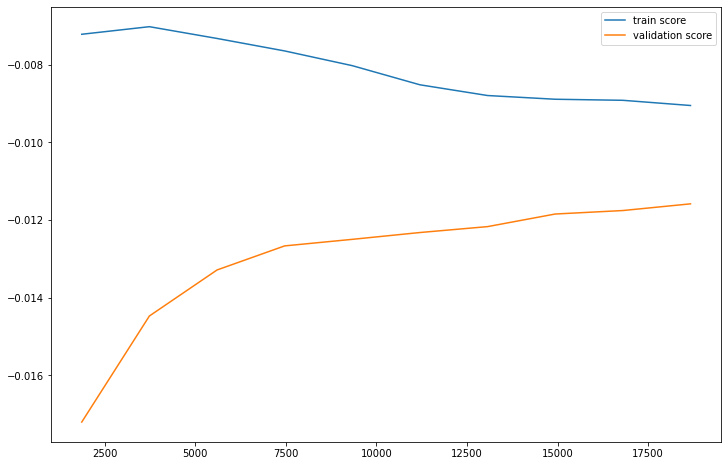

In [19]:
evaluation(model)

## optimisation

In [20]:
hyper_params = {
    'max_leaf_nodes' : [30,60,80],
    'learning_rate' : [0.1,0.15,0.2,0.25,0.3]
}

In [21]:
grid = GridSearchCV(model, hyper_params, scoring='neg_mean_absolute_error',cv=4)
grid.fit(xtrain,ytrain)
print(grid.best_params_)

{'learning_rate': 0.15, 'max_leaf_nodes': 80}


## prediction

In [22]:
test= encodage(clean(x_test))

In [23]:
y_pred = model.predict(test)

In [24]:
y_pred.shape[0]

13752

In [25]:
y_pred = pd.DataFrame({"p0q0" : y_pred})
y_pred.insert(0, "Unnamed: 0", [i+1 for i in range(y_pred.shape[0])], True)

In [26]:
filepath = Path('data_encodage.csv')
filepath.parent.mkdir(parents=True, exist_ok=True)
y_pred.to_csv(filepath, index = False)

In [27]:
y_pred

,Unnamed: 0,p0q0
0,1,0.239921
1,2,0.235941
2,3,0.239444
3,4,0.210198
4,5,0.235976
...,...,...
13747,13748,0.114297
13748,13749,0.127462
13749,13750,0.105057
13750,13751,0.149766
